In [1]:
# libraries
import pandas as pd
import numpy as np
import kaggle
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

In [2]:
# download and load dataset
kaggle.api.dataset_download_files('fronkongames/steam-games-dataset', path='datasets/', unzip=True)
df = pd.read_csv('datasets/games.csv')
df.head()

Dataset URL: https://www.kaggle.com/datasets/fronkongames/steam-games-dataset


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


DATA CLEANING

In [3]:
# first few columns are misaligned, aligning them correctly
corr_columns = ['Name', 'Release date', 'Estimated owners', 'Peak CCU',
                'Required age', 'Price', 'xyz']
df.rename(columns=dict(zip(df.columns[:7], corr_columns)), inplace=True)
df.reset_index(inplace=True)
df.rename(columns={"index": "AppID"}, inplace=True)
df.head()


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,xyz,DiscountDLC count,About the game,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [4]:
#df.columns.tolist()

In [5]:
# extract year from release date
df['Release date'] = pd.to_datetime(df['Release date'], errors = 'coerce')
df['year'] = df['Release date'].dt.year.astype('Int64')

In [6]:
# required columns
df1 = df[['Name','year','Genres','Tags','About the game', 'Categories']]

<Axes: xlabel='year'>

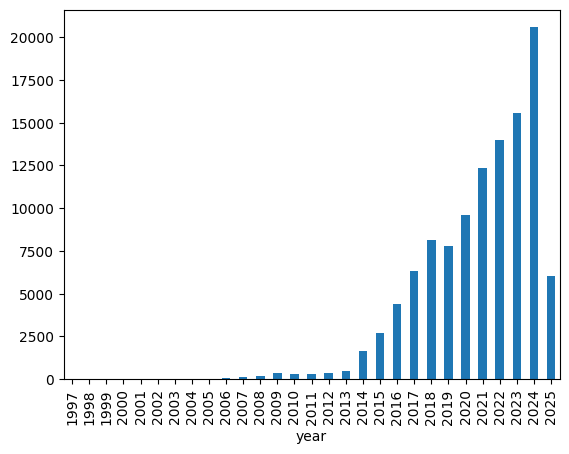

In [7]:
df1['year'].value_counts().sort_index().plot(kind='bar')

In [8]:
# We will consider data from 2017 to 2024
df1 = df1[(df1['year'] >= 2017) & (df1['year'] <= 2024)]

In [9]:
# check for missing values
df1.isnull().sum()

Name                  5
year                  0
Genres             5614
Tags              33876
About the game     5684
Categories         6582
dtype: int64

In [10]:
df1.shape

(94412, 6)

In [ ]:
# removing all missing values, keeping them would only introduce noise
df1.dropna(axis=0, inplace = True)
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)
df1.shape

(59599, 6)

In [12]:
df1

,Name,year,Genres,Tags,About the game,Categories
0,Train Bandit,2017,"Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",THE LAW!! Looks to be a showdown atop a train....,"Single-player,Steam Achievements,Full controll..."
1,Henosis™,2020,"Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",HENOSIS™ is a mysterious 2D Platform Puzzler w...,"Single-player,Full controller support"
2,Two Weeks in Painland,2020,"Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",ABOUT THE GAME Play as a hacker who has arrang...,"Single-player,Steam Achievements"
3,Wartune Reborn,2021,"Adventure,Casual,Free to Play,Massively Multip...","Turn-Based Combat,Massively Multiplayer,Multip...",Feel tired of auto-fight? Feel tired of boring...,"Single-player,Multi-player,MMO,PvP,Online PvP,..."
4,TD Worlds,2022,"Indie,Strategy","Tower Defense,Rogue-lite,RTS,Replay Value,Perm...","TD Worlds is a dynamic, highly strategical gam...","Single-player,Steam Achievements,Steam Cloud"
...,...,...,...,...,...,...
59594,Tank Blitz: Underdog Division,2024,"Action,Indie,Early Access","Action,Arcade,Shooter,2D Platformer,Top-Down S...",Tank Blitz: is a retro-style 2D top-down tank...,"Single-player,Steam Achievements,Family Sharing"
59595,Race or Crash: Secret Racer League,2024,"Action,Indie,Racing","Racing,Action,Combat Racing,Arcade,Automobile ...",Break through your rivals and destroy their ca...,"Single-player,Steam Achievements,Partial Contr..."
59596,East Trade Tycoon: Inheritance,2024,"Casual,Simulation","Casual,Simulation,Trading,2D,Cartoon,Historica...",Eastern Trade Tycoon: Inheritance is a simulat...,"Single-player,Steam Achievements,Steam Cloud,F..."
59597,VR Store Simulator,2024,"Simulation,Strategy","Immersive Sim,Strategy,VR,Management,Casual,Re...",🌟 Step into the exhilarating world of retail w...,"Single-player,VR Only,Family Sharing"


TEXT PREPROCESSING

In [ ]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() #lowercase
    text = re.sub(r'[^a-zA-Z\s]','',text) #remove non-alphabetic
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) #lemmatization
    return text

In [14]:
df1['Name'] = df1['Name'].apply(preprocess_text)
df1['About the game'] = df1['About the game'].apply(preprocess_text)
df1.head()

,Name,year,Genres,Tags,About the game,Categories
0,train bandit,2017,"Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",the law look to be a showdown atop a train thi...,"Single-player,Steam Achievements,Full controll..."
1,henosis,2020,"Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",henosis is a mysterious d platform puzzler whe...,"Single-player,Full controller support"
2,two week in painland,2020,"Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",about the game play a a hacker who ha arranged...,"Single-player,Steam Achievements"
3,wartune reborn,2021,"Adventure,Casual,Free to Play,Massively Multip...","Turn-Based Combat,Massively Multiplayer,Multip...",feel tired of autofight feel tired of boring n...,"Single-player,Multi-player,MMO,PvP,Online PvP,..."
4,td world,2022,"Indie,Strategy","Tower Defense,Rogue-lite,RTS,Replay Value,Perm...",td world is a dynamic highly strategical game ...,"Single-player,Steam Achievements,Steam Cloud"


In [ ]:
# set+ lowercase + split tags and genres (to ensure distinct extraction)
df1['Tags']=df1['Tags'].apply(lambda x:set(x.lower().split()))
df1['Genres']=df1['Genres'].apply(lambda x:set(x.lower().split()))
df1['Categories'] = df1['Categories'].apply(lambda x: set(x.lower().split()))
df1.head()

,Name,year,Genres,Tags,About the game,Categories
0,train bandit,2017,"{action,indie}","{graphics,2d,retro,arcade,score, attack,minima...",the law look to be a showdown atop a train thi...,"{leaderboards,remote, controller, play, on, tv..."
1,henosis,2020,"{adventure,casual,indie}","{manipulation,casual,indie, platformer,puzzle-...",henosis is a mysterious d platform puzzler whe...,"{single-player,full, controller, support}"
2,two week in painland,2020,"{adventure,indie}","{content,story, indie,adventure,nudity,violent...",about the game play a a hacker who ha arranged...,"{achievements, single-player,steam}"
3,wartune reborn,2021,"{play,massively, to, multiplayer,rpg,strategy,...","{strategy,god, rpg,exploration,pvp,mmorpg,turn...",feel tired of autofight feel tired of boring n...,"{single-player,multi-player,mmo,pvp,online, pv..."
4,td world,2022,"{indie,strategy}","{narration,stylized,real, tactics,strategy,min...",td world is a dynamic highly strategical game ...,"{single-player,steam, cloud, achievements,steam}"


In [ ]:
# trimming dataset to prevent kernel crashes
df1 = df1.sample(n=30000, random_state=42)

In [ ]:
# combine 'Name', 'Tags', 'Genres', and 'Categories' into a single feature for similarity calculation
df1['text'] = df1['Name'] + ' ' + df1['About the game'] + ' ' + df1['Tags'].apply(lambda x: ' '.join(x)) + ' ' + df1['Genres'].apply(lambda x: ' '.join(x)) + ' ' + df1['Categories'].apply(lambda x: ' '.join(x))

df1.head()

,Name,year,Genres,Tags,About the game,Categories,text
47849,cast,2023,"{casual,indie,strategy}","{graphics,crafting,funny,logic,level, platform...",cast is a decryption game that combine platfor...,"{cloud,includes, single-player,steam, level, e...",cast cast is a decryption game that combine pl...
15550,happy penguin vr,2017,"{action,adventure,indie,simulation,sports}","{indie,simulation,action,adventure,sports,vr,c...",happy penguin vr is a casual vr game in the ga...,{single-player},happy penguin vr happy penguin vr is a casual ...
4448,freelancer life simulator,2021,"{adventure,casual,indie,simulation}","{management,3d,first-person,realistic,logic,re...",freelancer life simulator do you like independ...,"{achievements, single-player,steam}",freelancer life simulator freelancer life simu...
52578,touhou danmaku kagura phantasia lost,2024,"{action,adventure,casual,indie}","{protagonist,fantasy,singleplayer,indie,post-a...",touhou danmaku kagura phantasia lostis a rebui...,"{single-player,full, controller, support}",touhou danmaku kagura phantasia lost touhou da...
6072,windy kingdom,2020,"{action,adventure,indie,rpg,simulation,strateg...","{access,sandbox,survival,open, rpg,action,adve...",introduce this is a sandbox game project the s...,"{single-player,steam, cloud, achievements,steam}",windy kingdom introduce this is a sandbox game...


FEATURE ENGINEERING

In [ ]:
# convert text into numerical vectors
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df1['text'])


# print(f"TF-IDF Matrix type: {type(tfidf_matrix)}")

tfidf_matrix.shape

(30000, 101295)

SIMILARITY INDEX

In [ ]:
# cosine similarity between games
similarity_matrix = cosine_similarity(tfidf_matrix,dense_output=False)

#print(f"Cosine Similarity Matrix type: {type(similarity_matrix)}") # to check whether it's sparse or no

# similarity_matrix[0]


In [ ]:
def recommender(game_name, top_n = 10):
    """
    recommends top N similar games based on the cosine similarity scores.

    :param game_name: name of the input game to base recommendations on.
    :param top_n: number of top recommendations to return.
    :return: df of recommended games with similarity percentage.
    
    """
    # index in df
    try:
        idx = df1[df1['Name'] == game_name].index[0]
    except IndexError:
        print(f"Game '{game_name}' not found.")
        return []

    # sparse row to dense array
    similarity_scores = similarity_matrix[idx].toarray().flatten()

    # enumerate and sort scores
    sorted_scores = sorted(list(enumerate(similarity_scores)), key=lambda x: x[1], reverse=True)

    # top 10 similar games (excluding input game)
    recommendations = []
    for i in sorted_scores[1:top_n+1]:
        game = df1.iloc[i[0]]['Name']
        score = round(float(i[1]) * 100, 2)
        recommendations.append((game, f"{score}%"))
    
    return pd.DataFrame(recommendations, columns=["Recommended Game", "Similarity"])


# example
recommender('train bandit')


,Recommended Game,Similarity
0,that level again d,31.16%
1,evolution of a mini world physic wonderland,23.9%
2,projection first light,22.8%
3,luminus,21.98%
4,double hard,21.58%
5,synzzball,21.24%
6,lonely path,20.64%
7,theme of dark and light,20.51%
8,circuit dude,20.39%
9,paper cant fly,20.37%


In [21]:
df1[df1['Name'] == 'that level again d']


,Name,year,Genres,Tags,About the game,Categories,text
54656,that level again d,2024,"{casual,indie}","{casual,puzzle,3d, platformer,idler,puzzle-pla...",get ready for an allnew challenge in this thre...,"{sharing, single-player,steam, achievements,fa...",that level again d get ready for an allnew cha...
